In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os.path import join
import os
import xarray as xr

import crime_patterns.utilities as utils
import crime_patterns.config as config
import crime_patterns.data_management as dm

from crime_patterns.final import plotting
from crime_patterns.analysis import point_patterns 

from pysal.viz import splot
from splot.esda import plot_moran

from pysal.explore import esda
from pysal.lib import weights
import libpysal
from libpysal.weights import Queen, Rook, KNN
from pysal.model import spreg

%load_ext autoreload
%autoreload 2

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
src = config.SRC
bld = config.BLD
data_raw = src / "data"
data_clean = bld / "python" / "data"
results_dir = bld / "python" / "results" 
plots_dir = bld / "python" / "figures"

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [3]:
## define paths
shapefiles_dir = os.path.join(data_raw, "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_lsoa_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")
london_greater_area_shp_path = os.path.join(data_clean,  "Greater_London_Area.shp")

crime_incidences_path = os.path.join(data_clean, r"city-of-london-burglaries-2019-cleaned.csv") 
imd_ward_shp_path = os.path.join(data_clean, r"IMD_Ward_2019.shp")
imd_lsoa_shp_path = os.path.join(data_clean, r"IMD_LSOA_2019.shp")
burglary_ward_shp_path = os.path.join(data_clean, r"MPS_Ward_Level_burglary_2019.shp")

In [4]:
london_lsoa = gpd.read_file(london_lsoa_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)
london_greater_area = gpd.read_file(london_greater_area_shp_path)

In [5]:
imd_ward = gpd.read_file(imd_ward_shp_path)
imd_lsoa = gpd.read_file(imd_lsoa_shp_path)
burglary_ward = gpd.read_file(burglary_ward_shp_path)

In [6]:
lsoa_total_pop = dm.aggregate_regional_level_data(
                                                lower_level_gdf = imd_lsoa,
                                                upper_level_gdf = london_ward,
                                                ID_column_name = "GSS_CODE",
                                                crs = config.CRS,
                                                )[["GSS_CODE", "TotPop", "geometry"]]

C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\src\crime_patterns\data_management\clean_data.py:141: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_gdf = agg_gdf_groups.sum()


In [7]:
# Setup figure and axis
height = 8
width = height*0.75

Text(0.5, 1.0, 'IMD Score by LSOA')

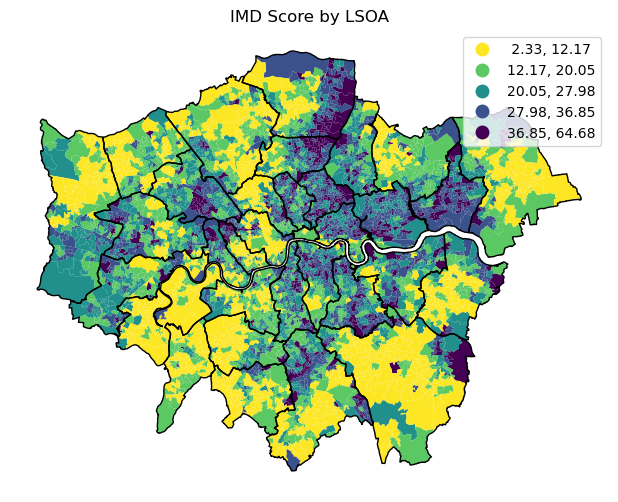

In [8]:
fig, ax = plt.subplots(figsize=(height, width))

choropleth = imd_lsoa.plot(ax=ax, column="IMDScore", scheme='natural_breaks', legend=True, cmap="viridis_r")
# cbar = plt.colorbar(contours)
london_borough.to_crs(imd_lsoa.crs).plot(ax=ax, fc="None")
plt.axis(False)
ax.set_title("IMD Score by LSOA")

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0.5, 1.0, 'IMD Score by Ward')

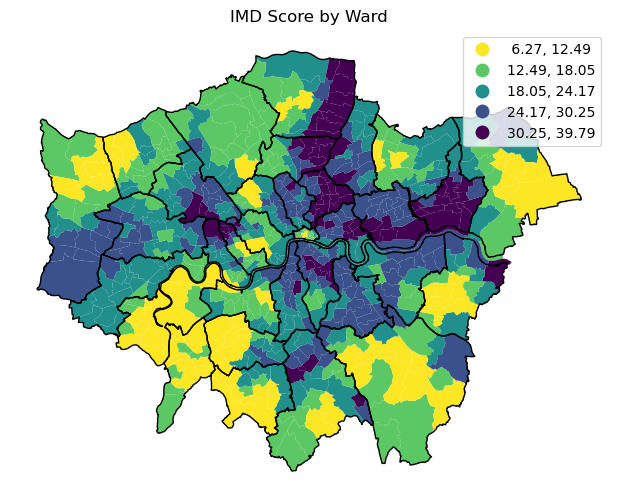

In [9]:
fig, ax = plt.subplots(figsize=(height, width))

choropleth = imd_ward.plot(ax=ax, column="IMDScore", scheme='natural_breaks', legend=True, cmap="viridis_r")
# cbar = plt.colorbar(contours)
london_borough.to_crs(imd_ward.crs).plot(ax=ax, fc="None")
plt.axis(False)
ax.set_title("IMD Score by Ward")

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0.5, 1.0, 'No. of Burglaries by Ward')

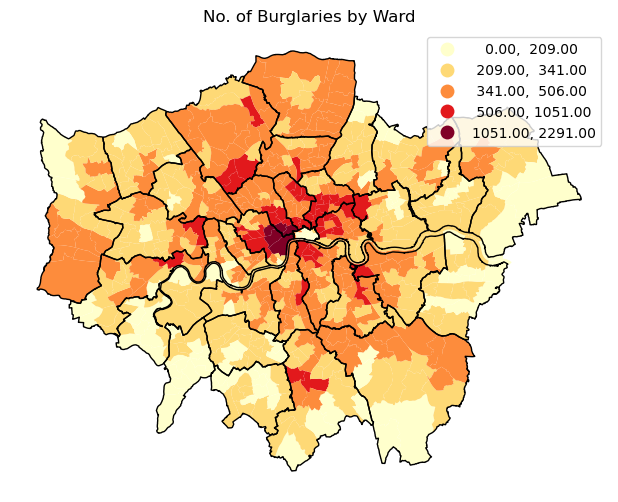

In [10]:
fig, ax = plt.subplots(figsize=(height, width))

choropleth = burglary_ward.plot(ax=ax, column="2019_total", scheme='natural_breaks', legend=True, cmap="YlOrRd")
# cbar = plt.colorbar(contours)
london_borough.to_crs(burglary_ward.crs).plot(ax=ax, fc="None")
plt.axis(False)
ax.set_title("No. of Burglaries by Ward")

In [11]:
db = burglary_ward[["GSS_CODE", '2019_total']].merge(imd_ward.drop("geometry", axis=1), on="GSS_CODE")

In [12]:
db["TotPop"] = lsoa_total_pop["TotPop"]

In [13]:
db["burglary_rate"] = db["2019_total"] / db["TotPop"]

In [14]:
db #.set_index("GSS_CODE", inplace=True)

,GSS_CODE,2019_total,IMDScore,IncScore,EmpScore,EduScore,HDDScore,CriScore,BHSScore,EnvScore,IDCScore,IDOScore,CYPScore,ASScore,GBScore,WBScore,IndScore,OutScore,TotPop,burglary_rate
0,E05000405,73.0,13.308564,0.093655,0.066667,17.020836,-0.758667,-0.239623,23.685781,16.680800,0.128623,0.103547,-0.123694,0.321000,-0.051606,1.526747,-0.245364,0.356053,16660,0.004382
1,E05000414,134.0,12.485331,0.085593,0.057328,10.633721,-0.825103,-0.120476,24.965950,22.374823,0.110750,0.111363,-0.482724,0.261393,-0.192989,2.033863,-0.037745,0.693881,23188,0.005779
2,E05000401,130.0,11.851539,0.075348,0.057511,5.211088,-0.705657,-0.452258,26.441773,25.092826,0.087448,0.148832,-0.820566,0.164963,-0.242086,2.424143,0.174285,0.580695,28931,0.004493
3,E05000400,140.0,11.189619,0.078397,0.057072,6.438296,-0.992904,-0.387617,24.717009,24.386916,0.094024,0.102745,-0.938052,0.227413,-0.041372,1.711251,0.033250,0.692291,26927,0.005199
4,E05000402,194.0,13.610404,0.096553,0.063229,5.915442,-0.822192,-0.196669,26.387078,27.334043,0.112744,0.152675,-1.031410,0.218203,-0.182663,2.303133,0.141067,0.843290,30121,0.006441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,E05000002,0.0,22.367790,0.128840,0.083868,13.714926,-0.352466,-1.418345,42.575002,37.397706,0.126006,0.202305,-0.158297,0.205892,-0.442155,4.857196,-0.071002,1.802782,1923,0.000000
645,E05000008,0.0,13.584000,0.014000,0.011000,1.771000,-0.676000,-1.560000,46.314000,49.165000,0.010000,0.035000,-0.852000,0.045000,0.571000,4.153000,0.674000,1.850000,802,0.000000
646,E05000012,59.0,16.198683,0.100894,0.067963,5.210499,-0.369125,-1.242338,32.217249,33.642510,0.151495,0.181425,-0.746807,0.132644,-0.911832,4.029287,0.094543,1.468390,4404,0.013397
647,E05000021,118.0,20.282672,0.112414,0.064357,12.199158,-0.208354,-0.500246,33.251216,45.182019,0.223603,0.350058,-0.001421,0.161967,-1.162823,4.399339,0.328947,2.071386,9113,0.012949


In [15]:
standardized_db = (db - db.mean()) / db.std()

C:\Users\Mumu\AppData\Local\Temp\ipykernel_18296\1581005927.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  standardized_db = (db - db.mean()) / db.std()
C:\Users\Mumu\AppData\Local\Temp\ipykernel_18296\1581005927.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  standardized_db = (db - db.mean()) / db.std()


In [16]:
# normalized_db = (db-db.min())/(db.max()-db.min())

In [17]:
all_score_names = standardized_db.columns[standardized_db.columns.str.contains("Score")]

In [18]:
len(all_score_names)

16

In [19]:
dependent_variable_name = 'burglary_rate'
independent_variable_names = ['IncScore', 'EmpScore', 'EnvScore', 'EduScore', 'IMDScore', 'BHSScore', ] # 'IMDScore', 'BHSScore', 'EduScore', 

In [20]:
# Fit OLS model
nonspatial_model = spreg.OLS(
    # Dependent variable
    standardized_db[[dependent_variable_name]].values,
    # Independent variables
    standardized_db[all_score_names].values,
    # Dependent variable name
    name_y=dependent_variable_name,
    # Independent variable name
    name_x=independent_variable_names,
)

In [21]:
print(nonspatial_model.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :burglary_rate                Number of Observations:         649
Mean dependent var  :      0.0000                Number of Variables   :          17
S.D. dependent var  :      1.0000                Degrees of Freedom    :         632
R-squared           :      0.4967
Adjusted R-squared  :      0.4839
Sum squared residual:     326.162                F-statistic           :     38.9762
Sigma-square        :       0.516                Prob(F-statistic)     :   3.186e-83
S.E. of regression  :       0.718                Log likelihood        :    -697.623
Sigma-square ML     :       0.503                Akaike info criterion :    1429.246
S.E of regression ML:      0.7089                Schwarz criterion     :    1505.328

----------------------------------------------------------------------------

#### Analysis

In [6]:
densities = point_patterns.evaluate_hotspots(longitudes=crime_incidences["Longitude"], latitudes=crime_incidences["Latitude"], region=london_greater_area)

In [7]:
densities.to_netcdf(os.path.join(results_dir, "kernel_density_estimates.nc"), mode='w', format="NETCDF4", engine="netcdf4")

In [8]:
with xr.open_dataset(os.path.join(results_dir, "kernel_density_estimates.nc")) as densities:
    
    densities.load()

In [9]:
X_coords, Y_coords, densities = densities["lon"].to_numpy(), densities["lat"].to_numpy(), densities["densities"].to_numpy()

In [10]:
densities

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [11]:
dbscan = point_patterns.cluster_crime_incidents_dbscan(
                        latitudes=crime_incidences["Latitude"],
                        longitudes=crime_incidences["Longitude"],
                        epsilon=1.5, # km
                        min_samples=330,
                        )

In [12]:
labels = dbscan.labels_

In [13]:
utils.save_object_to_pickle(dbscan, os.path.join(results_dir, "dbscan.pickle"))

'C:\\Users\\Mumu\\Desktop\\Bonn Econ\\Winter22-23\\EPP\\crime_patterns\\bld\\python\\results\\dbscan.pickle'

In [14]:
dbscan = utils.load_object_from_pickle(os.path.join(results_dir, "dbscan.pickle"))

#### Plotting

In [15]:
# Setup figure and axis
height = 8
width = height*0.75

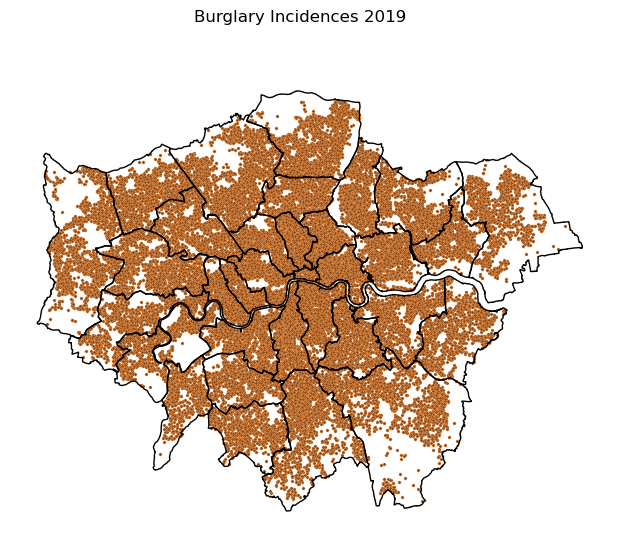

In [16]:
fig, ax = plotting.plot_crime_incidents(crime_incidences["Longitude"], crime_incidences["Latitude"], london_borough, figsize=(height, width))

plt.suptitle("Burglary Incidences 2019")
fig.savefig(os.path.join(plots_dir, 'burglary_incidents.png'), dpi=300, bbox_inches='tight')

In [ ]:
fig, ax, cbar = plotting.plot_hotspots(X_coords, Y_coords, densities, london_borough, figsize=(height, width))

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Density (KDE)", rotation=270)

plt.suptitle("Burglary Hotspots")
plt.savefig(os.path.join(plots_dir, 'burglary_hotspots.png'), dpi=300, bbox_inches='tight')

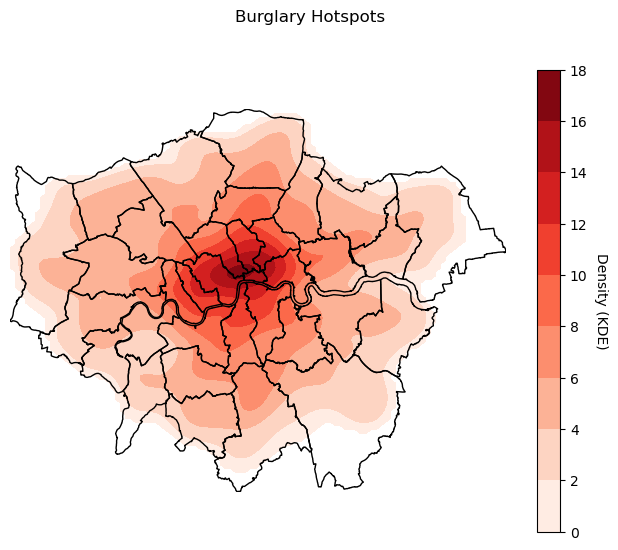

In [17]:
fig, ax, cbar = plotting.plot_hotspots(X_coords, Y_coords, densities, london_borough, figsize=(height, width))

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Density (KDE)", rotation=270)

plt.suptitle("Burglary Hotspots")
plt.savefig(os.path.join(plots_dir, 'burglary_hotspots_transparent.png'), dpi=300, bbox_inches='tight', transparent=True)

In [ ]:

fig, ax = plotting.plot_dbscan_clusters(crime_incidences, labels, london_borough, figsize=(height, width))

ax.legend(bbox_to_anchor = (0, 0.5))
plt.suptitle("Clustered Burglary Incidences (DBCAN)")

fig.savefig(os.path.join(plots_dir, 'burglary_clusters.png'), dpi=300, bbox_inches='tight')

<Axes: >

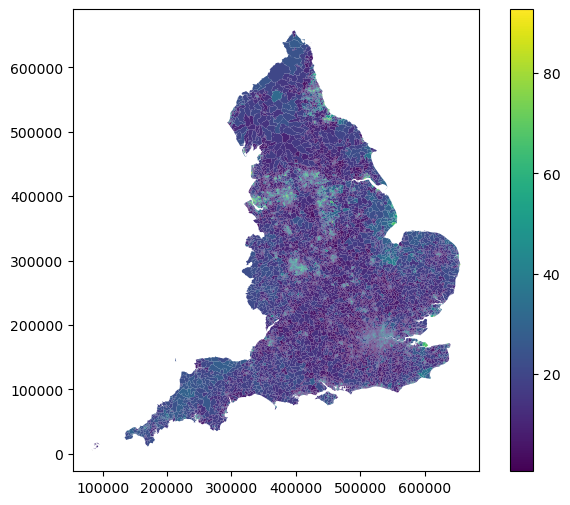

In [15]:
imd.plot(column="IMDScore", figsize=(height, width), legend=True)

In [20]:
join = imd.sjoin(london_lsoa.to_crs(imd.crs), how="inner")

In [28]:
london_lsoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,0,107.6,581,2.3,"POLYGON ((544642.680 179824.674, 544766.313 17..."
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,0,20.4,663,3.1,"POLYGON ((546579.195 181097.813, 546687.036 18..."
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,117,125.8,646,2.7,"POLYGON ((544536.486 179447.115, 544602.630 17..."
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,0,32.3,591,3.1,"POLYGON ((546415.745 180152.270, 546320.715 18..."


In [35]:
join_grouped = london_lsoa.merge(join.groupby(by='lsoa11cd').mean(), left_on='LSOA11CD', right_on='LSOA11CD'.lower(), how='inner')

C:\Users\Mumu\AppData\Local\Temp\ipykernel_14636\943420664.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  join_grouped = london_lsoa.merge(join.groupby(by='lsoa11cd').mean(), left_on='LSOA11CD', right_on='LSOA11CD'.lower(), how='inner')


In [36]:
type(join_grouped)

geopandas.geodataframe.GeoDataFrame

Text(0.5, 1.0, 'IMD Score by LSOA')

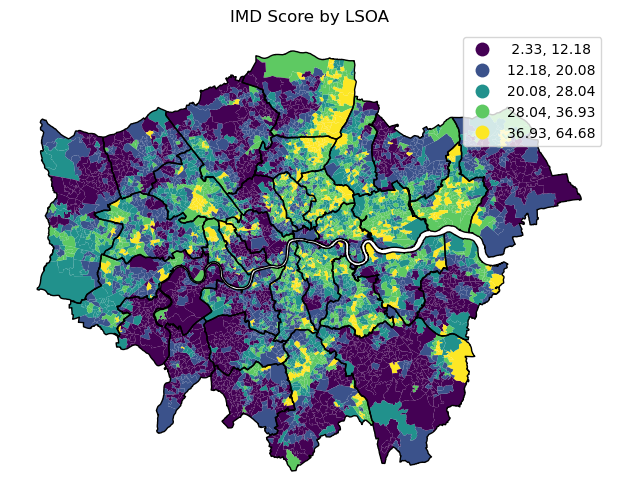

In [45]:

fig, ax = plt.subplots(figsize=(height, width))

choropleth = join_grouped.plot(ax=ax, column="IMDScore", scheme='natural_breaks', legend=True)
# cbar = plt.colorbar(contours)
london_borough.to_crs(imd.crs).plot(ax=ax, fc="None")
plt.axis(False)
ax.set_title("IMD Score by LSOA")


In [ ]:
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Density (KDE)", rotation=270)